เคสนี้เราสร้างโมเดลจากข้อมูลตรง ๆ เปรียบเทียบกับ ข้อมูลที่ถูก Feature Engineering ว่าประสิทธิภาพ จะแตกต่างกันอย่างไร

# 0. Magic Commands


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import Library

In [2]:
from fastai import *
from fastai.tabular import *

Save Token จาก Kaggle วิธีทำลองอ่าน [ep ก่อน ๆ](https://www.bualabs.com/archives/751/multi-label-image-classification-satellite-imagery-deep-learning-machine-learning-image-classification-ep-5/)

In [3]:
# ! {sys.executable} -m pip install kaggle --upgrade

In [4]:
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

# 2. ข้อมูล

เคสนี้เราจะใช้ Dataset [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/) จาก Kaggle

In [5]:
path = Config.data_path()/'titanic'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/titanic')

รัน cell ด้านล่างเพื่อดาวน์โหลด ข้อมูล Training Set และ Test Set

In [6]:
# ! kaggle competitions download -c titanic -f train.csv -p {path}  
# ! kaggle competitions download -c titanic -f test.csv -p {path}  

ls ดูว่ามีไฟล์อะไรบ้าง

In [7]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/titanic/test.csv'),
 PosixPath('/home/jupyter/.fastai/data/titanic/submission.csv'),
 PosixPath('/home/jupyter/.fastai/data/titanic/models'),
 PosixPath('/home/jupyter/.fastai/data/titanic/train.csv')]

โหลดไฟล์ train.csv, test.csv ขึ้นมาดู

In [8]:
dataframe_train = pd.read_csv(path/'train.csv')
dataframe_test = pd.read_csv(path/'test.csv')
dataframe_train.shape, dataframe_test.shape

((891, 12), (418, 11))

Sample ดู 10 แถว

In [9]:
dataframe_train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
279,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1,C.A. 2673,20.2500,NaN,S
364,365,0,3,"O'Brien, Mr. Thomas",male,NaN,1,0,370365,15.5000,NaN,Q
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0000,B94,S
334,335,1,1,"Frauenthal, Mrs. Henry William (Clara Heinshei...",female,NaN,1,0,PC 17611,133.6500,NaN,S
842,843,1,1,"Serepeca, Miss. Augusta",female,30.0,0,0,113798,31.0000,NaN,C
791,792,0,2,"Gaskell, Mr. Alfred",male,16.0,0,0,239865,26.0000,NaN,S
72,73,0,2,"Hood, Mr. Ambrose Jr",male,21.0,0,0,S.O.C. 14879,73.5000,NaN,S
575,576,0,3,"Patchett, Mr. George",male,19.0,0,0,358585,14.5000,NaN,S
122,123,0,2,"Nasser, Mr. Nicholas",male,32.5,1,0,237736,30.0708,NaN,C
761,762,0,3,"Nirva, Mr. Iisakki Antino Aijo",male,41.0,0,0,SOTON/O2 3101272,7.1250,NaN,S


Test Set จะเหมือนกัน แต่ไม่มี Survived ให้เราเป็นผู้เติม Survived แล้วส่งให้ Kaggle ตรวจคะแนน

In [10]:
dataframe_test.sample(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
333,1225,3,"Nakid, Mrs. Said (Waika Mary"" Mowad)""",female,19.0,1,1,2653,15.7417,NaN,C
408,1300,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,NaN,Q
84,976,2,"Lamb, Mr. John Joseph",male,NaN,0,0,240261,10.7083,NaN,Q
195,1087,3,"Karlsson, Mr. Julius Konrad Eugen",male,33.0,0,0,347465,7.8542,NaN,S
135,1027,3,"Carlsson, Mr. Carl Robert",male,24.0,0,0,350409,7.8542,NaN,S
115,1007,3,"Chronopoulos, Mr. Demetrios",male,18.0,1,0,2680,14.4542,NaN,C
406,1298,2,"Ware, Mr. William Jeffery",male,23.0,1,0,28666,10.5000,NaN,S
44,936,1,"Kimball, Mrs. Edwin Nelson Jr (Gertrude Parsons)",female,45.0,1,0,11753,52.5542,D19,S
103,995,3,"Johansson Palmquist, Mr. Oskar Leander",male,26.0,0,0,347070,7.7750,NaN,S
14,906,1,"Chaffee, Mrs. Herbert Fuller (Carrie Constance...",female,47.0,1,0,W.E.P. 5734,61.1750,E31,S


ลองดูสถิติข้อมูล

In [11]:
dataframe_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [12]:
dataframe_train.describe(include='O')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Jonsson, Mr. Carl",male,1601,G6,S
freq,1,577,7,4,644


จะเห็นว่า Column Age, Cable, Embarked ขาดไป ไม่ครบ 891 โดยเฉพาะ Cabin ขาดเยอะมาก

In [13]:
dataframe_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [14]:
dataframe_test.describe(include='O')

,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Salomon, Mr. Abraham L",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


Test Set ก็คล้าย ๆ กัน แต่มี 1 Record ที่ Column Fare ขาดไป เพิ่มขึ้นมา

# 3. เตรียมข้อมูล



กำหนดว่า Column ไหน เป็นอะไร ถ้าไม่ใส่ในนี้คือเราจะไม่ใส่ใสโมเดล และต้องการ Preprocess อะไรบ้าง

Preprocess ทำอะไรกับ Training Set ก็จะต้องทำ Test Set แบบเดียวกัน 

เรื่อง Preprocess ด้วยการ FillMissing, Categorify, Normalize จะอธิบายต่อไป

In [15]:
dependent_variable = 'Survived'
category_column_names = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
continuous_column_names = ['Age', 'Fare']

preprocesses = [FillMissing, Categorify, Normalize]

เนื่องจากใน Test Set มี Fare หายไป 1 Record แต่ใน Training Set มีครบ เราจึงต้องใส่เพิ่มเอง ด้วยค่า Median

In [16]:
dataframe_test["Fare"] = dataframe_test.groupby("Pclass").transform(lambda x: x.fillna(x.median()))

กำหนดว่าจะเทรนกี่ Epoch และจะ Split Training Set, Validation Set อย่างไร

In [17]:
np.random.seed(42)
epoch = 12
lr = 1e-2
val_idx = np.random.permutation(dataframe_train.shape[0])[:180]

สร้าง Databunch จากการกำหนดค่าด้านบน

In [18]:
tabularlist_test = TabularList.from_df(dataframe_test, 
                           path=path, 
                           cat_names=category_column_names, 
                           cont_names=continuous_column_names, 
                           procs=preprocesses)

In [19]:
databunch = (TabularList.from_df(dataframe_train, path=path, 
                                 cat_names=category_column_names, 
                                 cont_names=continuous_column_names, 
                                 procs=preprocesses)
                           .split_by_idx(val_idx)
                           .label_from_df(cols=dependent_variable)
                           .add_test(tabularlist_test)
                           .databunch())

## สำรวจข้อมูล ##

ลองดูข้อมูลหลังจาก Preprocess เรียบร้อยแล้ว จะเห็นว่ามีแต่ Column ที่เรากำหนดไว้

*เราสามารถรัน cell นี้หลายครั้ง เพื่อเรียกดู batch ต่อ ๆ ไป ได้เรื่อย ๆ เป็นการสำรวจข้อมูล*

In [20]:
databunch.show_batch(rows=10)

Pclass,Sex,SibSp,Parch,Embarked,Age_na,Age,Fare,target
2,female,0,0,S,False,1.9856,-0.3190,1
3,male,0,0,S,False,-0.5523,-0.4873,0
1,female,2,0,S,False,1.8318,0.3632,1
3,male,0,0,S,False,-0.6292,-0.3171,0
1,male,0,0,S,True,-0.0908,0.3347,0
3,male,0,0,S,False,0.2937,-0.4772,0
1,female,1,0,C,False,1.4473,0.1348,1
2,male,1,0,S,False,0.3706,-0.1268,0
3,male,0,0,Q,True,-0.0908,-0.4762,0
2,male,1,0,S,False,0.9859,-0.1075,0


Output จะมี 2 class คือ 0 = ไม่รอด (Not Survived), 1 = รอด (Survived)

In [21]:
databunch.classes

[0, 1]

# 4. สร้างโมเดล

เนื่องจากตารางเล็ก ๆ ไม่ซับซ้อน เราจะสร้างโมเดล ที่ประกอบด้วย Dense Layer ที่ Deep แค่ 2 Hidden Layer โดยที่เหลือใช้ค่า Default ทั้งหมด เรื่องชนิดของ Layer เช่น Dense ไว้เราจะอธิบายต่อไป

In [22]:
learner = tabular_learner(databunch, layers=[256, 128],                                 
                          metrics=accuracy, wd=1e-1, 
                          callback_fns=ShowGraph)

# 5. เริ่มต้นเทรนโมเดล

เทรนด้วยค่า Default ไป 10 Cycle สามารถใช้ Learning Rate สูง ๆ ได้เลย

epoch,train_loss,valid_loss,accuracy,time
0,0.641672,0.679913,0.588889,00:00
1,0.572047,0.649422,0.588889,00:00
2,0.520741,0.604305,0.600000,00:00
3,0.498652,0.533804,0.788889,00:00
4,0.482598,0.470148,0.805556,00:00
5,0.466042,0.466875,0.800000,00:00
6,0.450735,0.462325,0.788889,00:00
7,0.435480,0.476599,0.800000,00:00
8,0.423370,0.472873,0.805556,00:00
9,0.410786,0.473647,0.794444,00:00


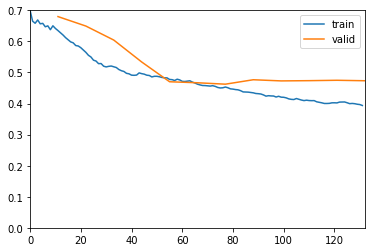

In [23]:
learner.fit_one_cycle(epoch, max_lr=lr)

จะเห็นได้ว่า เราได้ Accuracy ประมาณ 80% เราสามารถทำได้ดีกว่านี้หรือไม่ เราจะลองใช้ Feature Engineering เพื่อเตรียมข้อมูล เพื่อช่วยโมเดลให้เรียนรู้ได้ดีขึ้น

# 3/2. เตรียมข้อมูล ภาค 2 Feature Engineering

เราจะสร้าง List ของ Training Set, Test Set จะได้สะดวก แปลงทีเดียว 2 Dataframe

In [24]:
dataframe_bundle = [dataframe_test, dataframe_train]

สร้าง Column Title โดยตัดเอามาจาก Column Name

In [25]:
for dataframe in dataframe_bundle:    
    dataframe['Title'] = dataframe['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

เติมอายุที่ขาดไปด้วย ค่า Median ของแต่ละ Title ถ้าไม่มี Title นั้น ก็ให้เอา median ของทั้งหมด

In [26]:
for dataframe in dataframe_bundle:    
    dataframe["Age"].fillna(dataframe.groupby(["Title"])["Age"].transform('median'), inplace = True)
    dataframe['Age'].fillna(dataframe['Age'].median(), inplace = True)

สร้าง Column FamilySize จาก จำนวนพ่อแม่ + จำนวนพี่น้อง + ตัวเอง

In [27]:
for dataframe in dataframe_bundle:    
    dataframe['FamilySize'] = dataframe ['SibSp'] + dataframe['Parch'] + 1

สร้าง Column IsAlone = 1 ถ้าเดินทางคนเดียว

In [28]:
for dataframe in dataframe_bundle:    
    dataframe['IsAlone'] = 1 
    dataframe.loc[dataframe['FamilySize'] > 1, 'IsAlone'] = 0 

เนื่องจาก Fare ค่อนข้าง Vary ไม่ได้เป็นเส้นตรง เราจะแบ่ง Fare ออกเป็นช่วง ๆ จะมีความหมายมากขึ้น

In [29]:
for dataframe in dataframe_bundle:    
    dataframe['FareBin'] = pd.qcut(dataframe['Fare'].astype(int), 6)

เนื่องจาก Age ค่อนข้าง Vary เด็กค่อนข้างมี % รอดเยอะกว่า ไม่ได้เป็นเส้นตรง เราจะแบ่ง Age ออกเป็นช่วง ๆ จะมีความหมายมากขึ้น

In [30]:
for dataframe in dataframe_bundle:    
    dataframe['AgeBin'] = pd.cut(dataframe['Age'].astype(int), 5)

ใน Column Title มีคำนำหน้าชื่อ ประหลาด ๆ อาจจะเป็นยศ หรือ ภาษายุโรป etc. พวกที่มีคนสองคน เราจะเแปลงเป็น Rare 

In [31]:
dataframe_train.Title.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Major             2
Mlle              2
Ms                1
Don               1
Mme               1
the Countess      1
Jonkheer          1
Sir               1
Lady              1
Capt              1
Name: Title, dtype: int64

ส่วนภาษายุโรป เราก็จะแปล ตามเพศไป

In [32]:
for dataframe in dataframe_bundle:
    dataframe['Title'] = dataframe['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataframe['Title'] = dataframe['Title'].replace('Mlle', 'Miss')
    dataframe['Title'] = dataframe['Title'].replace('Ms', 'Miss')
    dataframe['Title'] = dataframe['Title'].replace('Mme', 'Mrs')

จาก 12 Column  เราทำ Feature Engineering จนเพิ่มมาเป็น 17 Column

In [33]:
dataframe_train.shape, dataframe_test.shape

((891, 17), (418, 16))

แต่ Column เยอะก็ใช่ว่าจะดี จะทำให้โมเดลสับสน เราจะใช้ AgeBin, FareBin แทนที่ Age และ Fare

In [34]:
dependent_variable = 'Survived'
category_column_names = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'IsAlone', 'Title', 'FareBin', 'AgeBin']
continuous_column_names = ['FamilySize']

preprocesses = [FillMissing, Categorify, Normalize]

In [35]:
tabularlist_test = TabularList.from_df(dataframe_test, 
                           path=path, 
                           cat_names=category_column_names, 
                           cont_names=continuous_column_names, 
                           procs=preprocesses)

In [36]:
databunch = (TabularList.from_df(dataframe_train, path=path, 
                                 cat_names=category_column_names, 
                                 cont_names=continuous_column_names, 
                                 procs=preprocesses)
                           .split_by_idx(val_idx)
                           .label_from_df(cols=dependent_variable)
                           .add_test(tabularlist_test)
                           .databunch())

In [37]:
databunch.show_batch(rows=10)

Pclass,Sex,SibSp,Parch,Embarked,IsAlone,Title,FareBin,AgeBin,FamilySize,target
3,male,0,0,S,1,Mr,"(-0.001, 7.0]","(48.0, 64.0]",-0.5548,0
2,male,1,2,C,0,Mr,"(26.0, 52.0]","(16.0, 32.0]",1.2274,0
1,female,0,1,S,0,Mrs,"(52.0, 512.0]","(48.0, 64.0]",0.0393,1
3,male,0,0,S,1,Mr,"(-0.001, 7.0]","(16.0, 32.0]",-0.5548,0
1,male,0,0,S,1,Mr,"(26.0, 52.0]","(64.0, 80.0]",-0.5548,1
1,female,0,0,C,1,Miss,"(52.0, 512.0]","(32.0, 48.0]",-0.5548,1
1,male,1,1,S,0,Mr,"(26.0, 52.0]","(32.0, 48.0]",0.6333,1
1,female,0,0,S,1,Mrs,"(14.0, 26.0]","(32.0, 48.0]",-0.5548,1
3,male,0,0,C,1,Mr,"(-0.001, 7.0]","(16.0, 32.0]",-0.5548,0
3,female,0,0,S,1,Miss,"(-0.001, 7.0]","(16.0, 32.0]",-0.5548,1


# 4/2 สร้างโมเดล

In [38]:
learner = tabular_learner(databunch, layers=[256, 128],                                 
                          metrics=accuracy, wd=1e-1, 
                          callback_fns=ShowGraph)

# 5/2 เริ่มต้นเทรนโมเดล

epoch,train_loss,valid_loss,accuracy,time
0,0.583857,0.685683,0.588889,00:00
1,0.507532,0.668051,0.588889,00:00
2,0.479244,0.670133,0.588889,00:00
3,0.459448,0.614814,0.594444,00:00
4,0.441851,0.496278,0.811111,00:00
5,0.426751,0.456914,0.816667,00:00
6,0.415080,0.464407,0.816667,00:00
7,0.410440,0.493683,0.816667,00:00
8,0.401967,0.433764,0.805556,00:00
9,0.391430,0.435680,0.805556,00:00


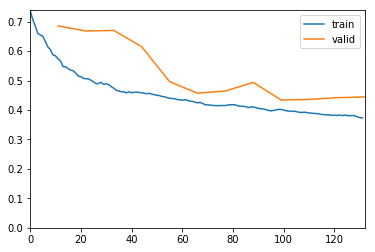

In [39]:
learner.fit_one_cycle(epoch, max_lr=lr)

## สำเร็จแล้ว ##

เพียงแค่เวลา 3 วินาที เราเทรน Model ได้ accuracy ประมาณ 0.82 หรือ ความแม่นยำประมาณ 82%

# 6. ดูผลลัพธ์

ลองดูข้อมูล Record ที่ 850

In [40]:
row = dataframe_train.iloc[666]
row

PassengerId                            667
Survived                                 0
Pclass                                   2
Name           Butler, Mr. Reginald Fenton
Sex                                   male
Age                                     25
SibSp                                    0
Parch                                    0
Ticket                              234686
Fare                                    13
Cabin                                  NaN
Embarked                                 S
Title                                   Mr
FamilySize                               1
IsAlone                                  1
FareBin                        (8.0, 14.0]
AgeBin                        (16.0, 32.0]
Name: 666, dtype: object

ให้โมเดลทำนายกัน

In [41]:
learner.predict(row)


(Category 0, tensor(0), tensor([0.9110, 0.0890]))

โมเดลทำนายได้ถูกต้อง

ให้โมเดลทำนาย Test Set

In [42]:
preds, _ = learner.get_preds(DatasetType.Test)

เตรียม Save ไฟล์เพื่อส่งประกวด

In [43]:
submission = pd.DataFrame({
        "PassengerId": dataframe_test["PassengerId"],
        "Survived": preds.argmax(1).numpy()
    })

In [44]:
submission.to_csv(path/'submission.csv', index=False)

รัน Cell ด้านล่างเพื่อส่งประกวด วันนึง เราสามาถส่งได้แค่ 10 ครั้งเท่านั้น

In [45]:
# ! kaggle competitions submit titanic -f {path/'submission.csv'} -m "My submission"

## อันดับบน Leaderboard

แล้วเราไปเปิดเว็บ หน้า Leader Board ดูผลคะแนนของเรา เมื่อทดสอบกับ Test Set


| Name           | Submitted    | Wait time | Execution time | Score   |
|----------------|--------------|-----------|----------------|---------|
| submission.csv | 10 hours ago | 0 seconds | 1 seconds      | 0.80382 |


เทียบกับคนอื่น จะเห็นว่าอยู่ประมาณ Top 10% อยู่ประมาณอันดับที่ 1154 จาก 11241


| #    | Team Name     |   Score |
|------|---------------|--------:|
| 1152 | IGSLOCAL      | 0.80382 |
| 1153 | Pavlo Fesenko | 0.80382 |
| 1154 | gnoparus      | 0.80382 |
| 1155 | sns0627       | 0.79904 |
| 1156 | Diego Nieto   | 0.79904 |

# 7. สรุป

1. Feature Engineering สามารถช่วยให้โมเดล ค้นหาความหมายที่ซ่อนอยู่ในข้อมูลได้ง่ายขึ้น โดยเฉพาะถ้าเรามีข้อมูลไม่มาก 
1. เราไม่จำเป็นต้องมีความรู้ Domain Expert ลึกซึ้งมาก ก็สามารถทำ Feature Engineering ได้
1. ระหว่างการทำ Feature Engineering การศึกษาความเป็นมาของข้อมูล แต่ละ Column และการ Plot กราฟดู Correlation กันระหว่าง Column จะช่วยได้มาก

ใน ep ต่อไปเราจะพูดถึงการทำ Feature Engineering ข้อมูลประเภท Time Series

# Credit 

* [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/)
* [A Data Science Framework: To Achieve 99% Accuracy](https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy)
* [Titanic Data Science Solutions](https://www.kaggle.com/startupsci/titanic-data-science-solutions)
* [What is the difference between pandas.qcut and pandas.cut](https://stackoverflow.com/questions/30211923/what-is-the-difference-between-pandas-qcut-and-pandas-cut)